In [76]:
import os
import cv2
import random

import requests
from bs4 import BeautifulSoup
from io import BytesIO

from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
import numpy as np

In [16]:
def get_label(id):
    label_dict = {0 : "Child", 1: "Cobra", 2: 'Downward Dog', 3:"Lunge", 4 : "Mountain", 5 : "Worrior"}
    return label_dict[id]

In [17]:
def scrape_images(query,n = 10):
    query_images = []
    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
}
    for i in range(10):
        link = "https://www.shutterstock.com/fr/search/"+query+"?people_number=1&age=20s&mreleased=true&page="+str(i)
        result = requests.get(link, headers = headers)
        soup = BeautifulSoup(result.text, 'html.parser')
        images = soup.find_all("img", class_ = "mui-1l7n00y-thumbnail")
        for image in images:
            query_images.append(image.get("src"))
    return query_images

In [18]:
def make_image_array(image):
    response = requests.get(image)
    img = Image.open(BytesIO(response.content))
    img = img.convert("RGB")
    img = np.array(img)
    img_resize = cv2.resize(img, (224,224))
    return(img_resize/255)

In [28]:
queries = ["child-pose-yoga","cobra-pose-yoga", "downward-dog-yoga", "mountain-pose-yoga", "lunge-pose-yoga", "warrior-pose-yoga"]
total_images = []
n_images_per_class = []
for query in tqdm(queries):
    query_images = scrape_images(query)

    for image in tqdm(query_images):
        class_images = len(query_images)
        try:
          total_images.append(make_image_array(image))
        except UnidentifiedImageError:
          class_images -=1
          continue
        n_images_per_class.append(class_images)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

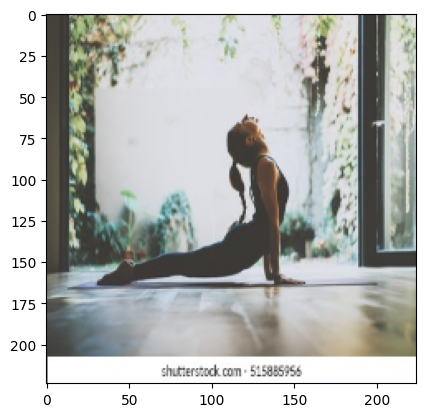

In [35]:
plt.imshow(total_images[180])

In [55]:
X = np.array(total_images)

In [56]:
y = np.ones((len(X),), dtype = "int32")

In [57]:
y[:180] = 0 # 5 for worrior
y[180:360] = 1 # 4 for mountain
y[360:540] = 2 #3 for lunge
y[540:720] = 3 # 2 for downward dog
y[720:900] = 4 # 1 for cobra
y[900:1080] = 5 # 0 for child


In [58]:
X,y= shuffle(X,y, random_state = 42)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

Text(0.5, 0, 'Mountain')

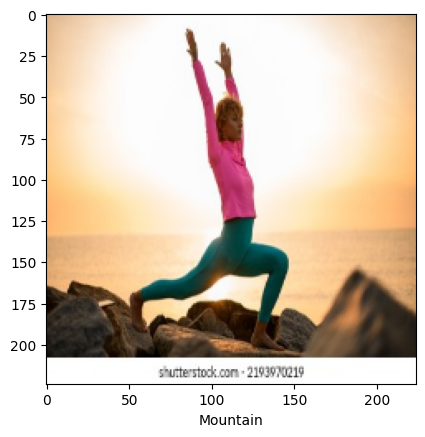

In [60]:
plt.imshow(X_train[190])
plt.xlabel(get_label(y_train[190]))

In [61]:
b =  np.zeros((y_train.size, y_train.max() + 1))
b[np.arange(y_train.size), y_train] = 1
y_train = b

In [63]:
b =  np.zeros((y_test.size, y_test.max() + 1))
b[np.arange(y_test.size), y_test] = 1
y_test = b

In [64]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [77]:
# Load the pre-trained VGG16 model
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

# Create the modified model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



473176280/473176280 [==============================] - 56s 0us/step


In [78]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                         

In [1]:
model.fit(aug.flow(X_train, y_train), epochs=20, validation_data=(X_test, y_test))


NameError: ignored